In [36]:
import Su22
import qiskit as qk
import numpy as np
from qiskit.tools.visualization import plot_histogram
from qiskit import IBMQ
from qiskit.tools.monitor import job_monitor
from qiskit.providers.aer.noise import NoiseModel
import matplotlib
import matplotlib.pyplot as plt
from qiskit.visualization import plot_bloch_multivector
from qiskit.tools.monitor import job_monitor

from qiskit import pulse              
from qiskit.circuit import Parameter 
from IPython.display import display
from qiskit import QuantumCircuit
from qiskit.circuit import Gate
import warnings
warnings.filterwarnings('ignore')
from qiskit.tools.jupyter import *
# The pulse simulator
from qiskit.providers.aer import PulseSimulator

# Object for representing physical models
from qiskit.providers.aer.pulse import PulseSystemModel
token = '792003cde0750f1452faa5cb5fe7c57da849e1119983f608e9a359d49cdb396391d6af09eedfb46af0a043a01103ed64da66835d1a318c0013d64ab3ebc1fe61'
qk.IBMQ.save_account(token=token)
qk.IBMQ.enable_account(token)
provider = IBMQ.get_provider(hub='ibm-q-ornl', group='ornl', project='phy147')
#backend = provider.get_backend("ibmq_jakarta")
from qiskit.test.mock import FakeJakarta

configrc.store_credentials:WARNING:2022-07-26 11:30:53,621: Credentials already present. Set overwrite=True to overwrite.


In [37]:
backend = provider.get_backend("ibmq_jakarta")
#backend = FakeJakarta()

## functions

In [38]:
import pickle

def loadData(inp):
    # for reading also binary mode is important
    dbfile = open(inp, 'rb')     
    db = pickle.load(dbfile)
    dbfile.close()
    return db

data=loadData('FGRAFS_controls/FGRAFS-controls_N-160_zero-endpoints-True.p')
temp = []
for i in data:
    for j in range(int(4)):
        temp.append(i)
print(len(temp), " " , len(data))

640   160


In [39]:
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, Aer
from qiskit.quantum_info import state_fidelity
from qiskit.providers.aer import noise

# Tomography functions
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
import qiskit.ignis.mitigation.measurement as mc
import time

def Full_tomography(circ, backend):
    state = QuantumCircuit(1)
    state.x(0)
    job = qk.execute(state, backend=Aer.get_backend('statevector_simulator'))
    state_results = job.result().get_statevector(state)
    t = time.time()
    test_circ = state_tomography_circuits(circ,[0])
    job = qk.execute(test_circ, backend=backend, shots=8192)
    test_state = StateTomographyFitter(job.result(), test_circ).fit()
    print('Time taken:', time.time() - t)
    return test_state


def plot_m(state):
    return 0

In [47]:
import numpy as np
import scipy.signal as si
import scipy.linalg as la
import matplotlib.pyplot as plt
import qiskit as qk
from qiskit import Aer
from qiskit.providers.ibmq.managed import IBMQJobManager

noise_power = 1e-3
num_noise_trajs = 1

def generate_noise_params(s_pow, w0):
    a = [1]
    NN = 512
    BW = 0.005 # changes narrowness of noise spectrum
    b = si.firwin(NN, BW)*np.cos(w0*np.pi*np.arange(NN))
    b = b/la.norm(b)*np.sqrt(s_pow)
    return a, b

def parametrize_circ(circ,noise_traj_list,backend):
    par = qk.circuit.ParameterVector('thetha', length=int(len(circ)/64))
    batch = []
    for traj in noise_traj_list:
        with pulse.build(backend=backend,default_alignment='sequential') as temp:
            for j in range(int(len(circ)/64)):
                pulse.play(circ[j*64:(j+1)*64], pulse.drive_channel(0))
                pulse.shift_phase(par[j],pulse.drive_channel(0))
            pulse.measure(qubits=[0], registers=[pulse.MemorySlot(0)])
        for i in range(len(par)):
            temp.assign_parameters({par[i]: traj[i]}, inplace=True)
        batch.append(temp)
    return batch

def parametrize_circ_1(circ,noise_traj_list,backend):
    par = qk.circuit.ParameterVector('thetha', length=int(len(circ)))
    batch = []
    for traj in noise_traj_list:
        with pulse.build(backend=backend,default_alignment='sequential') as temp:
            for j in range(int(len(circ))):
                pulse.play([circ[j]], pulse.drive_channel(0))
                pulse.shift_phase(par[j],pulse.drive_channel(0))
            #pulse.measure(qubits=[0], registers=[pulse.MemorySlot(0)])
        for i in range(len(par)):
            temp.assign_parameters({par[i]: traj[i]}, inplace=True)
        batch.append(temp)
    return batch

def schwarma_trajectories(a, b, num_gates, num_trajectories):
    # a: coefficients of linear filter numerator
    # b: coefficients of linear filter demoninator
    # num_gates: number of gates in circuit to be "schwarmafied"
    # num_trajectories: number of noise trajectories required
    traj_list = []
    for _ in range(num_trajectories):
        angles = si.lfilter(b, a, np.random.randn(num_gates + 1000))[1000:]
        traj_list.append(angles)
    return traj_list

shots=1000

def Spec(data,start,end,num_center_freqs=100,backend=backend, option = 0):  
    #option 0 beaks upp pulse into 64dt chuncks option 1 will extend pulses to 64dt
    if(option):
        num_gates=int(len(data))
    else:
        num_gates=int(len(data)/64)
    circ_batch = []
    center_idxs=[]
    centers=[]
    all_probs = np.zeros([num_center_freqs, 2])
    for center_idx, center in enumerate(np.linspace(start, end, num_center_freqs)): # vary noise center frequency
        center_idxs.append(center_idx)
        centers.append(center)
        #print('Probing Filter Function at Normalized Frequency: ', center)
        # Generate noise trajectories
        a, b = generate_noise_params(noise_power, center)
        noise_traj_list = np.array(schwarma_trajectories(a, b, num_gates, num_noise_trajs))
    
        # Build noisy circuit dictionary
        if(not option):
            circ_batch+=(parametrize_circ(data,noise_traj_list,backend))
        else:
            circ_batch+=(parametrize_circ_1(data,noise_traj_list,backend))

        # Run circuits
    '''job_manager = IBMQJobManager()
    job_set = job_manager.run(circ_batch, backend=backend, name=('Spectrosopy'+str(time.strftime("%H:%M:%S", time.localtime()))))
    results = job_set.results()

    # Compile Results
    cc=0
    prob = 0
    counter = 0
    for i in range(int(len(circ_batch)/num_noise_trajs)):
        for circ in circ_batch[i*num_noise_trajs:((i+1)*num_noise_trajs)]:
            zero_counts = results.get_counts(cc).get('1')
            prob += zero_counts/shots
            cc+=1
        prob = prob/num_noise_trajs
        all_probs[int(center_idxs[counter]), :] = centers[counter], prob
        counter+=1
        prob=0
    '''
    return all_probs, circ_batch

## recovery

In [ ]:
import pickle

def loadData(inp):
    # for reading also binary mode is important
    dbfile = open(inp, 'rb')     
    db = pickle.load(dbfile)
    dbfile.close()
    return db

data_x = loadData('system_x_gate_comp.p')
data_128t = loadData('128_dt_Spectrosopy_comparison_true.p') 
data_128f = loadData('128_dt_Spectrosopy_comparison_false.p')

16.965269467526507


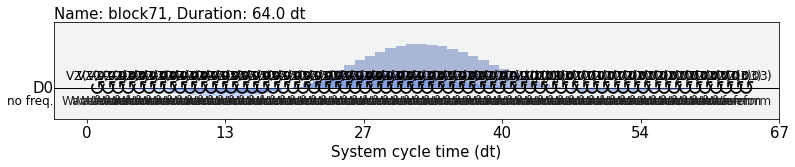

In [51]:
import time
data=loadData('FGRAFS_controls/FGRAFS-controls_N-64_zero-endpoints-True.p')
test=np.array(data)
print(np.abs(test).max())
test= test/test.max()
t = time.time()
start=0.3
end=start+((0.98-0.02)/10)
all_probs, circ_batch= Spec(test,0.02,0.98,1,backend=backend,option=1)
circ_batch[0].draw()

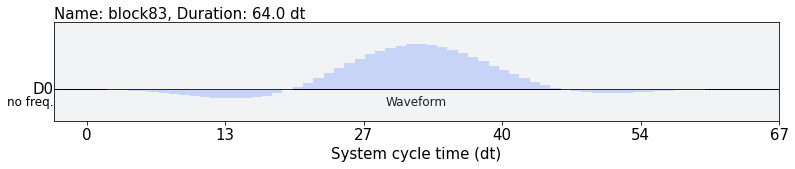

In [143]:
with pulse.build(backend=backend) as custom_Pulse_2:
    pulse.play(test,pulse.drive_channel(0))
#import qiskit.pulse.transforms.canonicalization as canon
#x=(canon.block_to_schedule(circ_batch[0])).instructions[1][1].operands
custom_Pulse_2.draw()

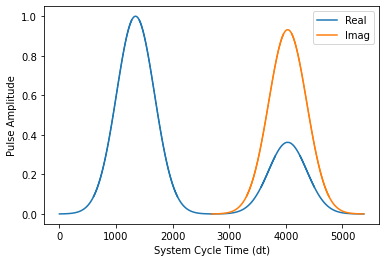

In [119]:
import matplotlib.pyplot as plt

from qiskit.pulse import Schedule, Gaussian, Play, ShiftPhase, DriveChannel
from qiskit.visualization.pulse_v2 import device_info, stylesheet
from qiskit.visualization.pulse_v2.events import ChannelEvents
from qiskit.visualization.pulse_v2.generators import gen_filled_waveform_stepwise

# Construct the Gaussian pulse and drive channels
gaussian_pulse = Gaussian(duration=2688, amp=1, sigma=336)
drive_chan0 = DriveChannel(0)
drive_chan1 = DriveChannel(1)

# Construct a schedule with different phase shifts on the two channels

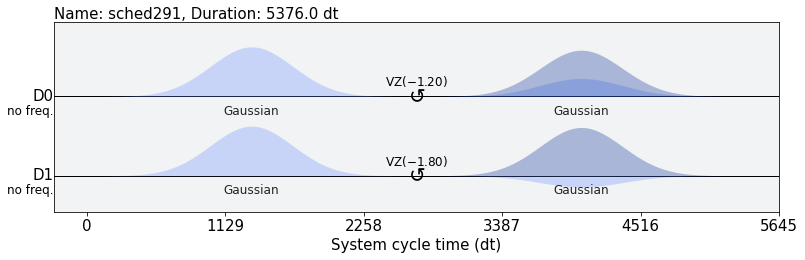

In [124]:
sched = Schedule()
sched += Play(gaussian_pulse, drive_chan0)
sched += ShiftPhase(1.2, drive_chan0)
sched += Play(gaussian_pulse, drive_chan0)
sched += Play(gaussian_pulse, drive_chan1)
sched += ShiftPhase(1.8, drive_chan1)
sched += Play(gaussian_pulse, drive_chan1)
sched.draw()

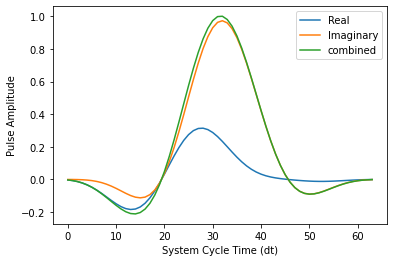

[8.33068834e-06+0.j 4.55077702e-05+0.j 1.63502684e-04+0.j
 4.61440372e-04+0.j 1.10235240e-03+0.j 2.31853199e-03+0.j
 4.39458817e-03+0.j 7.61807178e-03+0.j 1.21939891e-02+0.j
 1.81314070e-02+0.j 2.51258199e-02+0.j 3.24757966e-02+0.j
 3.90807984e-02+0.j 4.35630721e-02+0.j 4.45364272e-02+0.j
 4.10090622e-02+0.j 3.28624740e-02+0.j 2.13050667e-02+0.j
 9.17135449e-03+0.j 9.38571802e-04+0.j 2.36943383e-03+0.j
 1.97609780e-02+0.j 5.88725153e-02+0.j 1.23699561e-01+0.j
 2.15329957e-01+0.j 3.31140783e-01+0.j 4.64557240e-01+0.j
 6.05499417e-01+0.j 7.41507086e-01+0.j 8.59386530e-01+0.j
 9.47101757e-01+0.j 9.95566357e-01+0.j 1.00000000e+00+0.j
 9.60595467e-01+0.j 8.82379953e-01+0.j 7.74316013e-01+0.j
 6.47835317e-01+0.j 5.15098970e-01+0.j 3.87310955e-01+0.j
 2.73373091e-01+0.j 1.79074873e-01+0.j 1.06886183e-01+0.j
 5.62964318e-02+0.j 2.45478312e-02+0.j 7.56072087e-03+0.j
 8.49408845e-04+0.j 2.69411435e-04+0.j 2.50435010e-03+0.j
 5.27312882e-03+0.j 7.29800959e-03+0.j 8.11095307e-03+0.j
 7.78618015e-0

In [214]:
# Generate waveforms on channel 0
chan_events = ChannelEvents.load_program(canon.block_to_schedule(circ_batch[0]), drive_chan0)
waveforms = chan_events.get_waveforms()
line_data_lists = [gen_filled_waveform_stepwise(
                   waveform,
                   formatter=stylesheet.QiskitPulseStyle().formatter,
                   device=device_info.OpenPulseBackendInfo())
                   for waveform in waveforms]

final = [] 
real= []
imag = []
temp= []
# Plot the waveforms
plt.figure()
for line_data_list in line_data_lists:
    for line_data in line_data_list:
        if line_data.data_type == 'Waveform.Real':
            temp.append(line_data.xvals[0])
            real.append(line_data.yvals[0])
            if(len(line_data_list) == 1):
                imag.append(0j)
        elif line_data.data_type == 'Waveform.Imag':
            imag.append(line_data.yvals[0])
            if(len(line_data_list) == 1):
                temp.append(line_data.xvals[0])
                imag.append(0)
plt.xlabel("System Cycle Time (dt)")
plt.ylabel("Pulse Amplitude")
plt.plot(temp, real, color='C0', label='Real')
plt.plot(temp, imag, color='C1', label='Imaginary')
plt.plot(temp, (((np.array(real)+np.array(imag))/np.abs(np.array(real)+np.array(imag)))*np.sqrt(np.array(real)**2+np.array(imag)**2)), color='C2', label='combined')
#plt.plot(temp, test, color='C3', label='input')
plt.legend()
plt.show()
print(np.array(real)**2+np.array(imag)**2)

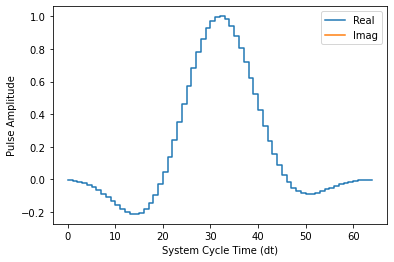

[[LineData(type=Waveform.Real, key=2273744909087328485)]]


In [146]:
# Generate waveforms on channel 0
chan_events = ChannelEvents.load_program(canon.block_to_schedule(custom_Pulse_2), drive_chan0)
waveforms = chan_events.get_waveforms()
line_data_lists = [gen_filled_waveform_stepwise(
                   waveform,
                   formatter=stylesheet.QiskitPulseStyle().formatter,
                   device=device_info.OpenPulseBackendInfo())
                   for waveform in waveforms]

# Plot the waveforms
plt.figure()
for line_data_list in line_data_lists:
    for line_data in line_data_list:
        if line_data.data_type == 'Waveform.Real':
            real, = plt.plot(line_data.xvals, line_data.yvals, color='C0', label='Real')
        elif line_data.data_type == 'Waveform.Imag':
            imag, = plt.plot(line_data.xvals, line_data.yvals, color='C1', label='Imag')
plt.xlabel("System Cycle Time (dt)")
plt.ylabel("Pulse Amplitude")
plt.legend(handles=[real, imag])
plt.show()
print(line_data_lists)

Text(0.5, 1.0, 'Noise Spectroscopy of Pulse sampled at each intervals')

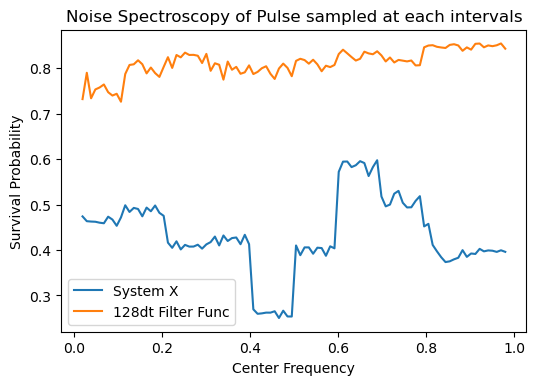

In [ ]:
# import numpy as np
import matplotlib.pyplot as plt
fig = plt.figure(dpi=100)
ax = fig.add_subplot(111)
ax.plot(data_x['option 1'][0][:,0],data_x['option 1'][0][:,1]/4,label='System X')
ax.plot(data_128t['option 1'][0][:,0],data_128t['option 1'][0][:,1]/4,label='128dt Filter Func')
ax.legend()
ax.set_ylabel('Survival Probability')
ax.set_xlabel('Center Frequency')
ax.set_title('Noise Spectroscopy of Pulse sampled at each intervals')

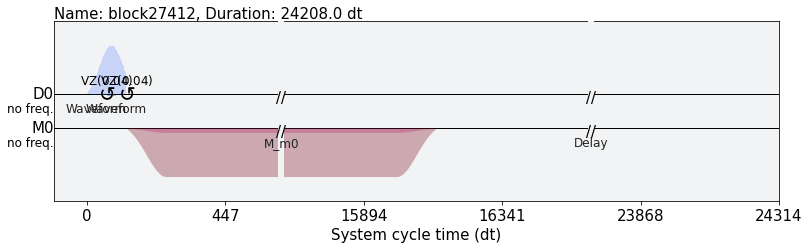

In [31]:
from qiskit import pulse
data_x['option 0'][1][50].draw()